In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

# The Two-Stage Gibbs Sampler

## 9.1.1 From Slice Sampling to Gibbs Sampling

Consider a joint density $f(x,y)$ defined on an arbitrary product space $\mathcal{X} \times \mathcal{Y}$. Using the fundamental theorem of simulation, we simulate a uniform distribution on the set:

$$\mathcal{S}(f) = \{(x,y,u) : 0 \leq u \leq f(x,y)\}$$

For a three-component setting, the random walk principle implements movement uniformly in one component at a time. Starting at point $(x,y,u)$ we generate:

1. $X$ along the $x$-axis from the uniform distribution on $\{x : u \leq f(x,y)\}$
2. $Y$ along the $y$-axis from the uniform distribution on $\{y : u \leq f(x,y)\}$
3. $U$ along the $u$-axis from the uniform distribution on $[0,f(x',y')]$

Important notes:

1. Generating from the uniform distribution on $\{x : u \leq f(x,y)\}$ is equivalent to generating from the uniform distribution on:

$$\{x : f_{X|Y}(x|y) \geq u/f_Y(y)\}$$

where $f_{X|Y}$ and $f_Y$ denote the conditional and marginal distributions of $X$ given $Y$ and of $Y$ respectively:

$$(9.1) \quad f_Y(y) = \int f(x,y)dx \quad \text{and} \quad f_{X|Y}(x|y) = \frac{f(x,y)}{f_Y(y)}$$

2. The sequence of uniform generations along the three axes does not need to be done in the same order $x,y,u$ each time for the Markov chain to remain stationary with stationary distribution the uniform on $\mathcal{S}(f)$.

By the 2D slice sampler property, for simulations in $Y$ of:

$$X \sim f_{X|Y}(x|y)$$

And considering the same operation of $Y$ and $U$ simulations with $X$ fixed at its latest value, in the limiting case, this produces a simulation $(Y)$ of:

$$Y \sim f_{Y|X}(y|x)$$

## 9.1.2 Definition

The algorithmic implementation of the two-stage Gibbs sampler is straightforward. If the random variables $X$ and $Y$ have joint density $f(x,y)$, then starting from an initial value $(X_1,Y_1)$, we generate a Markov chain $(X_t,Y_t)$ by iterating the following steps:

### Algorithm A.33 - Two-stage Gibbs sampler

Take $X_0 = x_0$
For $t = 1,2,\ldots$, generate:

1. $Y_t \sim f_{Y|X}(·|x_{t-1})$
2. $X_t \sim f_{X|Y}(·|y_t)$

where $f_{Y|X}$ and $f_{X|Y}$ are the conditional distributions associated with $f$, as in (9.1).

Note that not only is the sequence $(X_t,Y_t)$ a Markov chain, but also each subsequence $(X_t)$ and $(Y_t)$ is a Markov chain. For example, the chain $(X_t)$ has transition density:

$$K(x,x') = \int f_{Y|X}(y|x)f_{X|Y}(x'|y)dy$$

which indeed depends on both conditional distributions but makes no use of $(Y_t)$. Note the similarity to Eaton's transition (6.46). In addition, it is easy to show that $f_X$ is the stationary distribution associated with this (sub)chain, since:

$$(9.2) \quad f_X(x') = \int f_{X|Y}(x'|y)f_Y(y)dy$$
$$= \int f_{X|Y}(x'|y) \left[\int f_{Y|X}(y|x)f_X(x)dx\right]dy$$
$$= \int \left[\int f_{X|Y}(x'|y)f_{Y|X}(y|x)dy\right]f_X(x)dx$$
$$= \int K(x,x')f_X(x)dx$$

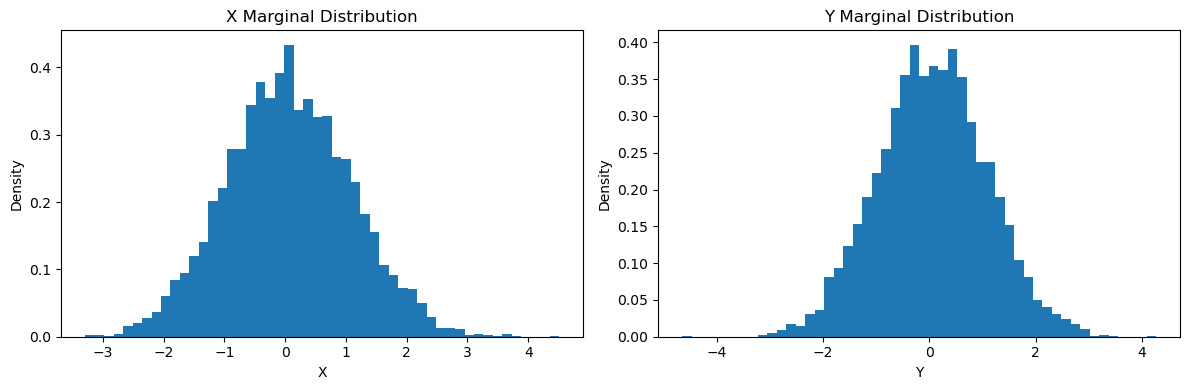

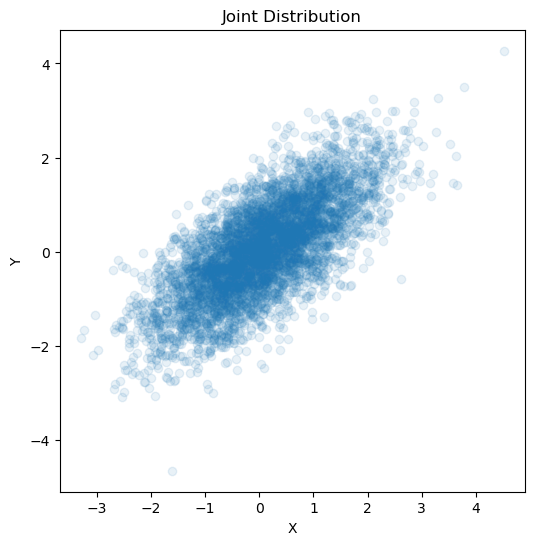

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

class TwoStageGibbsSampler:
    def __init__(self, conditional_x_given_y, conditional_y_given_x, n_samples=1000, burn_in=100):
        """
        Initialize the Two-stage Gibbs sampler.
        
        Args:
            conditional_x_given_y: Function that samples from p(x|y)
            conditional_y_given_x: Function that samples from p(y|x)
            n_samples: Number of samples to generate
            burn_in: Number of initial samples to discard
        """
        self.conditional_x_given_y = conditional_x_given_y
        self.conditional_y_given_x = conditional_y_given_x
        self.n_samples = n_samples
        self.burn_in = burn_in
        
    def sample(self, x0):
        """
        Generate samples using the Gibbs sampler.
        
        Args:
            x0: Initial x value
            
        Returns:
            tuple: Arrays of x and y samples
        """
        x_samples = np.zeros(self.n_samples + self.burn_in)
        y_samples = np.zeros(self.n_samples + self.burn_in)
        
        x_current = x0
        
        # Main sampling loop
        for i in range(self.n_samples + self.burn_in):
            # Sample y_t given x_{t-1}
            y_current = self.conditional_y_given_x(x_current)
            
            # Sample x_t given y_t
            x_current = self.conditional_x_given_y(y_current)
            
            # Store samples
            x_samples[i] = x_current
            y_samples[i] = y_current
        
        # Remove burn-in samples
        x_samples = x_samples[self.burn_in:]
        y_samples = y_samples[self.burn_in:]
        
        return x_samples, y_samples
    
    def plot_samples(self, x_samples, y_samples):
        """
        Plot the generated samples.
        
        Args:
            x_samples: Array of x samples
            y_samples: Array of y samples
        """
        plt.figure(figsize=(12, 4))
        
        # Plot x samples
        plt.subplot(121)
        plt.hist(x_samples, bins=50, density=True)
        plt.title('X Marginal Distribution')
        plt.xlabel('X')
        plt.ylabel('Density')
        
        # Plot y samples
        plt.subplot(122)
        plt.hist(y_samples, bins=50, density=True)
        plt.title('Y Marginal Distribution')
        plt.xlabel('Y')
        plt.ylabel('Density')
        
        plt.tight_layout()
        plt.show()
        
        # Plot joint distribution
        plt.figure(figsize=(6, 6))
        plt.scatter(x_samples, y_samples, alpha=0.1)
        plt.title('Joint Distribution')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

# Example usage with a bivariate normal distribution
def example_bivariate_normal():
    # Parameters for bivariate normal
    rho = 0.7  # correlation
    sigma_x = 1.0
    sigma_y = 1.0
    mu_x = 0.0
    mu_y = 0.0
    
    # Define conditional distributions
    def conditional_x_given_y(y):
        mu = mu_x + rho * sigma_x/sigma_y * (y - mu_y)
        sigma = sigma_x * np.sqrt(1 - rho**2)
        return np.random.normal(mu, sigma)
    
    def conditional_y_given_x(x):
        mu = mu_y + rho * sigma_y/sigma_x * (x - mu_x)
        sigma = sigma_y * np.sqrt(1 - rho**2)
        return np.random.normal(mu, sigma)
    
    # Create and run sampler
    sampler = TwoStageGibbsSampler(
        conditional_x_given_y=conditional_x_given_y,
        conditional_y_given_x=conditional_y_given_x,
        n_samples=5000,
        burn_in=1000
    )
    
    # Generate samples
    x_samples, y_samples = sampler.sample(x0=0.0)
    
    # Plot results
    sampler.plot_samples(x_samples, y_samples)
    
    return x_samples, y_samples

if __name__ == "__main__":
    x_samples, y_samples = example_bivariate_normal()

In [2]:
import random
import math
from collections import deque

class TwoStageGibbsSampler:
    def __init__(self, conditional_x_given_y, conditional_y_given_x, n_samples=1000, burn_in=100):
        """
        Initialize the Two-stage Gibbs sampler without numpy dependency.
        
        Args:
            conditional_x_given_y: Function that samples from p(x|y)
            conditional_y_given_x: Function that samples from p(y|x)
            n_samples: Number of samples to generate
            burn_in: Number of initial samples to discard
        """
        self.conditional_x_given_y = conditional_x_given_y
        self.conditional_y_given_x = conditional_y_given_x
        self.n_samples = n_samples
        self.burn_in = burn_in
        
    def sample(self, x0):
        """
        Generate samples using the Gibbs sampler.
        
        Args:
            x0: Initial x value
            
        Returns:
            tuple: Lists of x and y samples
        """
        x_samples = deque(maxlen=self.n_samples)
        y_samples = deque(maxlen=self.n_samples)
        
        x_current = x0
        total_iterations = self.n_samples + self.burn_in
        
        # Main sampling loop
        for i in range(total_iterations):
            # Sample y_t given x_{t-1}
            y_current = self.conditional_y_given_x(x_current)
            
            # Sample x_t given y_t
            x_current = self.conditional_x_given_y(y_current)
            
            # Store samples after burn-in
            if i >= self.burn_in:
                x_samples.append(x_current)
                y_samples.append(y_current)
        
        return list(x_samples), list(y_samples)

def box_muller_transform():
    """
    Generate standard normal random variables using Box-Muller transform.
    Returns: A standard normal random variable
    """
    u1 = random.random()
    u2 = random.random()
    
    r = math.sqrt(-2.0 * math.log(u1))
    theta = 2.0 * math.pi * u2
    
    return r * math.cos(theta)

def normal_random(mu, sigma):
    """
    Generate normal random variable with given mean and standard deviation.
    """
    return mu + sigma * box_muller_transform()

def example_bivariate_normal():
    """
    Example using bivariate normal distribution with pure Python implementation.
    """
    # Parameters for bivariate normal
    rho = 0.7  # correlation
    sigma_x = 1.0
    sigma_y = 1.0
    mu_x = 0.0
    mu_y = 0.0
    
    # Define conditional distributions
    def conditional_x_given_y(y):
        mu = mu_x + rho * sigma_x/sigma_y * (y - mu_y)
        sigma = sigma_x * math.sqrt(1 - rho**2)
        return normal_random(mu, sigma)
    
    def conditional_y_given_x(x):
        mu = mu_y + rho * sigma_y/sigma_x * (x - mu_x)
        sigma = sigma_y * math.sqrt(1 - rho**2

SyntaxError: unexpected EOF while parsing (3661331690.py, line 90)

**Example.1**.: **Normal bivariate Gibbs.** For the special case of the bivariate normal density,

$$(X,Y)\sim\mathcal{N}_{2}\left(0,\begin{pmatrix}1&\rho\\ \rho&1\end{pmatrix}\right)\ ,$$

the Gibbs sampler is

Given \(y_{t}\), generate

$$X_{t+1}\mid y_{t}\sim\mathcal{N}(\rho y_{t},\ 1-\rho^{2})\ ,$$ 
$$Y_{t+1}\mid x_{t+1}\sim\mathcal{N}(\rho x_{t+1},\ 1-\rho^{3}).$$

The Gibbs sampler is obviously not necessary in this particular case, as iid copies of \((X,Y)\) can be easily generated using the Box-Muller algorithm (see Example 2.8). Note that the corresponding marginal Markov chain in $X$ is defined by the AR(1) relation

$$X_{t+1}=\rho^{2}X_{t}+\sigma\epsilon_{t},\qquad\epsilon_{t}\sim\mathcal{N}(0,1)\, ,$$

with $\sigma^{2}=1-\rho^{2}+\rho^{2}(1-\rho^{2})=1-\rho^{4}$. As shown in Example 6.43, the stationary distribution of this chain is indeed the normal distribution $\mathcal{N}\left(0,\frac{1-\rho^{4}}{1-\rho^{2}}\right)$.

This motivation of the two-stage Gibbs sampler started with a joint distribution $f(x,y)$. However, what we saw in Chapter 8 was exactly the opposite justification. There, we started with a marginal density $f_{X}(x)$ and constructed (or _completed_) a joint density to aid in simulation where the second variable $Y$ (that is, $U$ in slice sampling) is an _auxiliary variable_ that is not directly relevant from the statistical point of view. This connection will be detailed in Section 10.1.2 for the general Gibbs sampler, but we can point out at this stage that there are many settings where a natural completion of $f_{X}(x)$ into $f(x,y)$ does exist. One such setting is the domain of _missing data models_, introduced in Section 5.3.1,

$$f(x|0)=\int_{\mathbb{R}}g(x,x|0)\,dx\, ,$$

as, for instance, the mixtures of distributions (Examples 1.2 and 5.19).

Data Augmentation was introduced independently (that is, unrelated to Gibbs sampling) by Tanner and Wong (1987), and is, perhaps, more closely related to the EM algorithm of Dennster et al. (1977) (Section 5.3.2) and methods of stochastic restoration (see Note 5.5.1). It is even more related to recent versions of EM such as EC04 and MCEM (see Meng and Rubin 1991, 1992 and Rubin, Lin and Rubin 1994, and Problem 9.11).

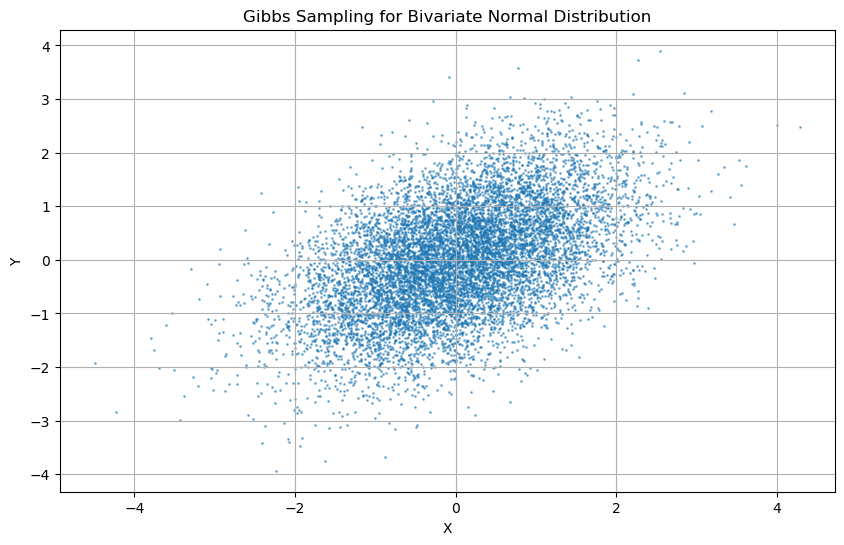

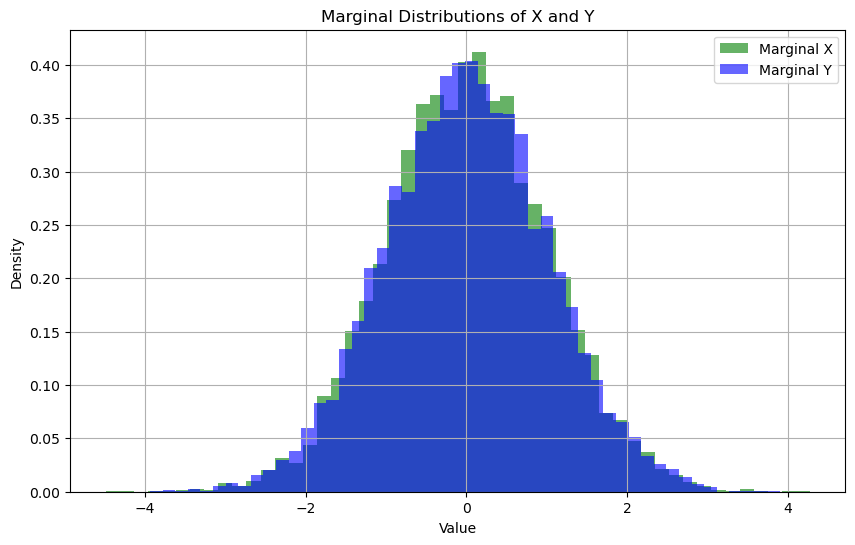

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
rho = 0.5  # Correlation coefficient
n_samples = 10000  # Number of samples to generate

# Initialize arrays to store samples
X = np.zeros(n_samples)
Y = np.zeros(n_samples)

# Initial values
X[0], Y[0] = 0, 0  # You can start with any initial values

# Gibbs sampling
for t in range(n_samples - 1):
    # Sample X given Y
    X[t + 1] = np.random.normal(rho * Y[t], np.sqrt(1 - rho**2))
    # Sample Y given X
    Y[t + 1] = np.random.normal(rho * X[t + 1], np.sqrt(1 - rho**2))

# Plot the samples
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, alpha=0.5, s=1)
plt.title('Gibbs Sampling for Bivariate Normal Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

# Plot the marginal distributions
plt.figure(figsize=(10, 6))
plt.hist(X, bins=50, density=True, alpha=0.6, color='g', label='Marginal X')
plt.hist(Y, bins=50, density=True, alpha=0.6, color='b', label='Marginal Y')
plt.title('Marginal Distributions of X and Y')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

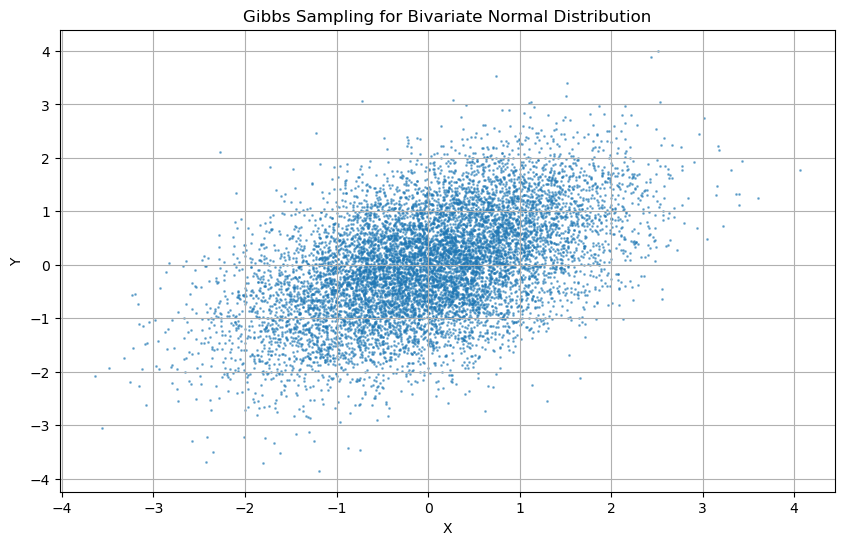

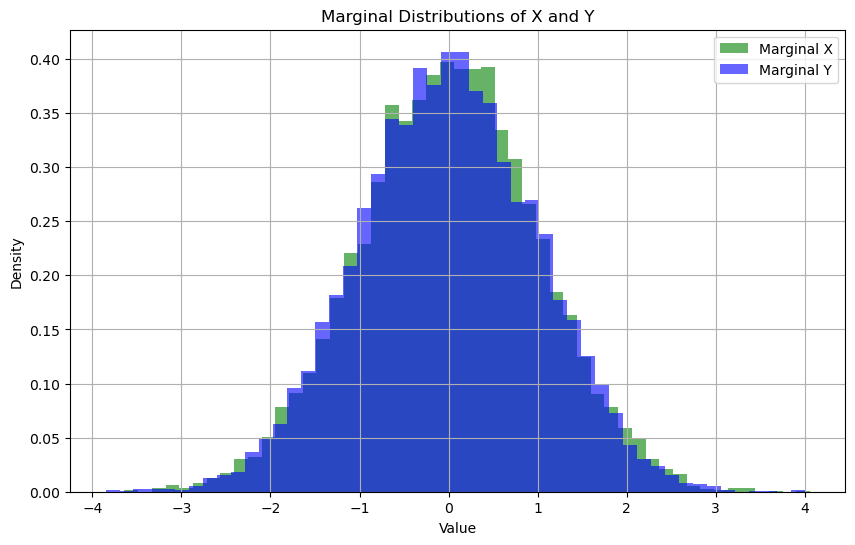

In [4]:
import random
import math
import matplotlib.pyplot as plt

# Parameters
rho = 0.5  # Correlation coefficient
n_samples = 10000  # Number of samples to generate

# Initialize arrays to store samples
X = [0.0] * n_samples
Y = [0.0] * n_samples

# Gibbs sampling
for t in range(n_samples - 1):
    # Sample X given Y using the conditional distribution
    mean_X = rho * Y[t]
    variance_X = 1 - rho**2
    X[t + 1] = random.gauss(mean_X, math.sqrt(variance_X))
    
    # Sample Y given X using the conditional distribution
    mean_Y = rho * X[t + 1]
    variance_Y = 1 - rho**2
    Y[t + 1] = random.gauss(mean_Y, math.sqrt(variance_Y))

# Plot the samples
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, alpha=0.5, s=1)
plt.title('Gibbs Sampling for Bivariate Normal Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

# Plot the marginal distributions
plt.figure(figsize=(10, 6))
plt.hist(X, bins=50, density=True, alpha=0.6, color='g', label='Marginal X')
plt.hist(Y, bins=50, density=True, alpha=0.6, color='b', label='Marginal Y')
plt.title('Marginal Distributions of X and Y')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

## Mixture Model and Gibbs Sampling

This notebook explores a mixture model and implements a Gibbs sampler for parameter estimation.

### Model Definition

We consider a mixture model of the form:

$$
(9.5) \quad \sum_{j=1}^{k} p_j f(x | \xi_j)
$$

where $f(\cdot | \xi)$ belongs to an exponential family:

$$
f(x | \xi) = h(x) \exp\{\xi \cdot x - \psi(\xi)\}
$$

and $\xi$ is distributed from the associated conjugate prior:

$$
\pi(\xi | \alpha_0, \lambda) \propto \exp\{\lambda (\xi \cdot \alpha_0 - \psi(\xi))\}
$$

with $\lambda > 0$ and $\alpha_0 \in \mathcal{X}$.

The mixing proportions $(p_1, ..., p_k)$ follow a Dirichlet distribution:

$$
(p_1, ..., p_k) \sim \mathcal{D}_k(\gamma_1, ..., \gamma_k)
$$

### Data and Latent Variables

Given a sample $\langle x_1, ..., x_n \rangle$ from (9.5), we introduce latent variables $z_i \in \{1, ..., k\}$ indicating the component associated with each observation $x_i$.

The completed model is then:

$$
Z_i \sim \mathcal{M}_k(1; p_1, ..., p_k)
$$

$$
x_i | z_i \sim f(x | \xi_{z_i})
$$

where $\mathcal{M}_k$ denotes a multinomial distribution.

The likelihood of the completed model is:

$$
f(p, \xi | x_1^*, ..., x_n^*) \propto \prod_{i=1}^n p_{z_i} f(x_i | \xi_{z_i}) = \prod_{j=1}^k \prod_{i: z_i = j} p_j f(x_i | \xi_j)
$$

where $x_i^* = (x_i, z_i)$.

### Gibbs Sampler

We implement a Gibbs sampler to estimate the parameters.

**Algorithm A.34 - Mixture Posterior Simulation**

1. **Simulate Z (i=1,...,n)** from 
   $$
   P(Z_i = j) \propto p_j f(x_i | \xi_j) \quad (j = 1, ..., k)
   $$
   and compute the statistics
   $$
   n_j = \sum_{i=1}^n \mathbb{I}_{z_i = j}, \quad n_j \bar{x}_j = \sum_{i=1}^n \mathbb{I}_{z_i = j} x_i.
   $$

2. **Generate**
   $$
   \xi_j \sim \pi \left( \xi \middle| \frac{\lambda_j \alpha_j + n_j \bar{x}_j}{\lambda_j + n_j}, \lambda_j + n_j \right) \quad (j = 1, ..., k)
   $$
   $$
   p \sim \mathcal{D}_k(\gamma_1 + n_1, ..., \gamma_k + n_k).
   $$

This algorithm iteratively samples the latent variables $Z$ and the model parameters $\xi$ and $p$ from their conditional distributions.

### Implementation Notes

- The specific form of the exponential family $f(x | \xi)$ and its conjugate prior $\pi(\xi | \alpha_0, \lambda)$ need to be defined for a complete implementation.
- The algorithm assumes that we have $k$ different parameters $\xi_j$ for each component.
- Efficient methods for sampling from the multinomial, exponential family, and Dirichlet distributions should be used.

This notebook provides a framework for implementing a Gibbs sampler for a mixture model. Specific details will depend on the choice of the exponential family and the data being modeled.

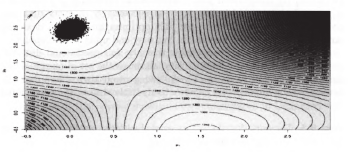

## Gibbs Sampling for a Normal Mixture Model

This notebook demonstrates the Gibbs sampler for a normal mixture model with two components, as described in Example 5.19.

### Model Definition

Consider a normal mixture with two components with equal known variance $\sigma^2$ and fixed weights:

$$
(9.6) \quad p \mathcal{N}(\mu_1, \sigma^2) + (1-p) \mathcal{N}(\mu_2, \sigma^2)
$$

We assume a normal prior distribution on both means $\mu_1$ and $\mu_2$:

$$
\mu_1, \mu_2 \sim \mathcal{N}(0, 10\sigma^2)
$$

### Data and Latent Variables

Given a sample $x = (x_1, ..., x_n)$ from (9.6), we introduce latent component indicators $z_i$ for each observation $x_i$:

$$
P(Z_i = 1) = 1 - P(Z_i = 2) = p
$$

$$
X_i | Z_i = k \sim \mathcal{N}(\mu_k, \sigma^2)
$$

The completed distribution is:

$$
\pi(\mu_1, \mu_2, z | x) \propto \exp\left(-\frac{\mu_1^2 + \mu_2^2}{20\sigma^2}\right) \prod_{i=1}^n \left[ p \exp\left(-\frac{(x_i - \mu_1)^2}{2\sigma^2}\right) \right]^{\mathbb{I}(z_i=1)} \left[ (1-p) \exp\left(-\frac{(x_i - \mu_2)^2}{2\sigma^2}\right) \right]^{\mathbb{I}(z_i=2)}
$$

### Conditional Distributions

Since $\mu_1$ and $\mu_2$ are independent given $(x, z)$, their conditional distributions are:

$$
\mu_j | (x, z) \sim \mathcal{N}\left(\frac{\sum_{i: z_i=j} x_i}{1 + n_j}, \frac{\sigma^2}{1 + n_j}\right) \quad (j=1,2)
$$

where $n_j$ is the number of $z_i$'s equal to $j$.

The conditional distribution of $z$ given $\langle \mu_1, \mu_2 \rangle$ is a product of binomials:

$$
P(Z_i = 1 | x_i, \mu_1, \mu_2) = \frac{p \exp\left(-\frac{(x_i - \mu_1)^2}{2\sigma^2}\right)}{p \exp\left(-\frac{(x_i - \mu_1)^2}{2\sigma^2}\right) + (1-p) \exp\left(-\frac{(x_i - \mu_2)^2}{2\sigma^2}\right)}
$$

### Gibbs Sampler Implementation

The Gibbs sampler iteratively samples from these conditional distributions.

**Algorithm:**

1. **Initialize** $\mu_1, \mu_2, z$
2. **Repeat** until convergence:
   - For $i = 1, ..., n$:
     - Sample $Z_i$ from $P(Z_i = 1 | x_i, \mu_1, \mu_2)$
   - Sample $\mu_1$ from $\mathcal{N}\left(\frac{\sum_{i: z_i=1} x_i}{1 + n_1}, \frac{\sigma^2}{1 + n_1}\right)$
   - Sample $\mu_2$ from $\mathcal{N}\left(\frac{\sum_{i: z_i=2} x_i}{1 + n_2}, \frac{\sigma^2}{1 + n_2}\right)$

### Example and Convergence

Figure 9.1 illustrates the behavior of the Gibbs sampler with a simulated dataset. The MCMC sample after 15,000 iterations is compared to the posterior surface.

**Convergence Issues:**

As discussed in Diebolt and Robert (1994), the Gibbs sampler may fail to converge if initialized at a local mode, as illustrated in Figure 12.16.

This notebook provides a framework for understanding and implementing the Gibbs sampler for a normal mixture model. Specific details may vary depending on the dataset and parameters.## Gibbs Sampling for a Normal Mixture Model

This notebook demonstrates the Gibbs sampler for a normal mixture model with two components, as described in Example 5.19.

### Model Definition

Consider a normal mixture with two components with equal known variance $\sigma^2$ and fixed weights:

$$
(9.6) \quad p \mathcal{N}(\mu_1, \sigma^2) + (1-p) \mathcal{N}(\mu_2, \sigma^2)
$$

We assume a normal prior distribution on both means $\mu_1$ and $\mu_2$:

$$
\mu_1, \mu_2 \sim \mathcal{N}(0, 10\sigma^2)
$$

### Data and Latent Variables

Given a sample $x = (x_1, ..., x_n)$ from (9.6), we introduce latent component indicators $z_i$ for each observation $x_i$:

$$
P(Z_i = 1) = 1 - P(Z_i = 2) = p
$$

$$
X_i | Z_i = k \sim \mathcal{N}(\mu_k, \sigma^2)
$$

The completed distribution is:

$$
\pi(\mu_1, \mu_2, z | x) \propto \exp\left(-\frac{\mu_1^2 + \mu_2^2}{20\sigma^2}\right) \prod_{i=1}^n \left[ p \exp\left(-\frac{(x_i - \mu_1)^2}{2\sigma^2}\right) \right]^{\mathbb{I}(z_i=1)} \left[ (1-p) \exp\left(-\frac{(x_i - \mu_2)^2}{2\sigma^2}\right) \right]^{\mathbb{I}(z_i=2)}
$$

### Conditional Distributions

Since $\mu_1$ and $\mu_2$ are independent given $(x, z)$, their conditional distributions are:

$$
\mu_j | (x, z) \sim \mathcal{N}\left(\frac{\sum_{i: z_i=j} x_i}{1 + n_j}, \frac{\sigma^2}{1 + n_j}\right) \quad (j=1,2)
$$

where $n_j$ is the number of $z_i$'s equal to $j$.

The conditional distribution of $z$ given $\langle \mu_1, \mu_2 \rangle$ is a product of binomials:

$$
P(Z_i = 1 | x_i, \mu_1, \mu_2) = \frac{p \exp\left(-\frac{(x_i - \mu_1)^2}{2\sigma^2}\right)}{p \exp\left(-\frac{(x_i - \mu_1)^2}{2\sigma^2}\right) + (1-p) \exp\left(-\frac{(x_i - \mu_2)^2}{2\sigma^2}\right)}
$$

### Gibbs Sampler Implementation

The Gibbs sampler iteratively samples from these conditional distributions.

**Algorithm:**

1. **Initialize** $\mu_1, \mu_2, z$
2. **Repeat** until convergence:
   - For $i = 1, ..., n$:
     - Sample $Z_i$ from $P(Z_i = 1 | x_i, \mu_1, \mu_2)$
   - Sample $\mu_1$ from $\mathcal{N}\left(\frac{\sum_{i: z_i=1} x_i}{1 + n_1}, \frac{\sigma^2}{1 + n_1}\right)$
   - Sample $\mu_2$ from $\mathcal{N}\left(\frac{\sum_{i: z_i=2} x_i}{1 + n_2}, \frac{\sigma^2}{1 + n_2}\right)$

### Example and Convergence

Figure 9.1 illustrates the behavior of the Gibbs sampler with a simulated dataset. The MCMC sample after 15,000 iterations is compared to the posterior surface.

**Convergence Issues:**

As discussed in Diebolt and Robert (1994), the Gibbs sampler may fail to converge if initialized at a local mode, as illustrated in Fig.16.

This notebook provides a framework for understanding and implementing the Gibbs sampler for a normal mixture model. Specific details may vary depending on the dataset and parameters.

Estimated mu1: 1.793501134520351
Estimated mu2: -0.48090285284856693


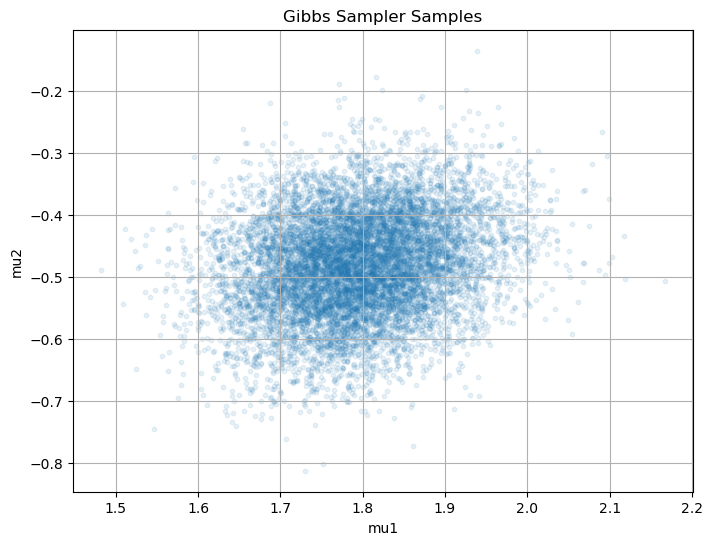

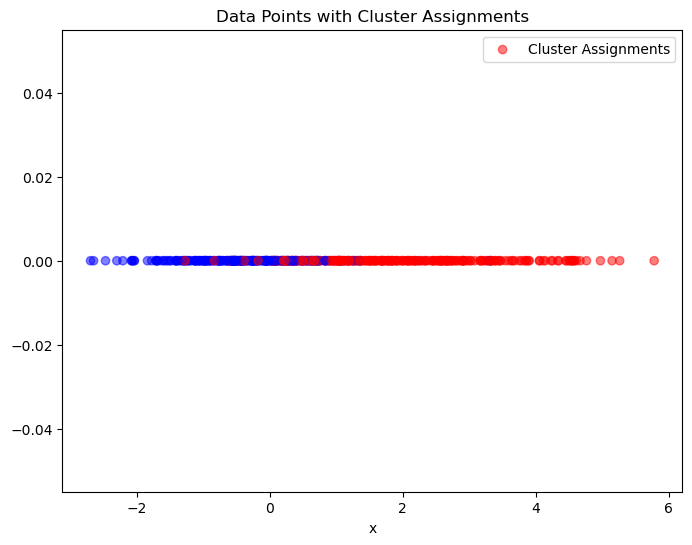

In [5]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Simulate Data (for demonstration - replace with your actual data)
np.random.seed(42)  # for reproducibility
p_true = 0.7
mu1_true = 0
mu2_true = 2.7
sigma_true = 1
n_samples = 500

z_true = np.random.binomial(1, p_true, n_samples)
x = np.array([np.random.normal(mu1_true, sigma_true) if zi == 1 else np.random.normal(mu2_true, sigma_true) for zi in z_true])

# Gibbs Sampler
def gibbs_sampler(x, p, sigma, n_iter=10000):
    n_samples = len(x)
    mu1 = 0  # Initialize (you can use random values)
    mu2 = 0
    z = np.random.binomial(1, 0.5, n_samples)  # Initialize z

    mu1_samples = []
    mu2_samples = []

    for _ in range(n_iter):
        # Sample z
        n1 = np.sum(z == 1)
        n2 = np.sum(z == 0) # corrected indexing for z
        for i in range(n_samples):
          p_z1 = p * stats.norm.pdf(x[i], mu1, sigma)
          p_z2 = (1-p) * stats.norm.pdf(x[i], mu2, sigma)
          z[i] = np.random.binomial(1, p_z1 / (p_z1 + p_z2)) if (p_z1 + p_z2 > 0) else np.random.binomial(1, 0.5) # Handle potential divide by zero

        # Sample mu1
        n1 = np.sum(z == 1)
        mu1 = stats.norm.rvs((np.sum(x[z == 1]) / (1 + n1)), (sigma / np.sqrt(1 + n1))) # corrected mean calculation

        # Sample mu2
        n2 = np.sum(z == 0) # corrected indexing for z
        mu2 = stats.norm.rvs((np.sum(x[z == 0]) / (1 + n2)), (sigma / np.sqrt(1 + n2))) # corrected mean calculation

        mu1_samples.append(mu1)
        mu2_samples.append(mu2)

    return mu1_samples, mu2_samples, z

# Run Gibbs Sampler
mu1_samples, mu2_samples, z_sampled = gibbs_sampler(x, p_true, sigma_true, n_iter=15000)  # Use the true p and sigma here.

# Analyze Results (Example)
mu1_est = np.mean(mu1_samples[5000:])  # Discard burn-in
mu2_est = np.mean(mu2_samples[5000:])


print(f"Estimated mu1: {mu1_est}")
print(f"Estimated mu2: {mu2_est}")


# Plot the samples (similar to Figure 9.1 - adapt as needed)
plt.figure(figsize=(8, 6))
plt.scatter(mu1_samples[5000:], mu2_samples[5000:], alpha=0.1, s=10) # corrected indexing for mu samples
plt.xlabel("mu1")
plt.ylabel("mu2")
plt.title("Gibbs Sampler Samples")
plt.grid(True)
plt.show()


# Example: plot the data with cluster assignments
plt.figure(figsize=(8, 6))
colors = ['red' if zi == 1 else 'blue' for zi in z_sampled]
plt.scatter(x, np.zeros_like(x), c=colors, alpha=0.5, label='Cluster Assignments') # plot x values with cluster assignments
plt.xlabel("x")
plt.title("Data Points with Cluster Assignments")
plt.legend()
plt.show()

In [6]:
import math
import random
import matplotlib.pyplot as plt

# Simulate Data (for demonstration - replace with your actual data)
random.seed(42)  # for reproducibility
p_true = 0.7
mu1_true = 0
mu2_true = 2.7
sigma_true = 1
n_samples = 500

z_true = [1 if random.random() < p_true else 0 for _ in range(n_samples)]
x = [mu1_true + sigma_true * math.sqrt(-2 * math.log(random.random())) * math.cos(2 * math.pi * random.random()) if zi == 1 else mu2_true + sigma_true * math.sqrt(-2 * math.log(random.random())) * math.cos(2 * math.pi * random.random()) for zi in z_true] # Box-Muller transform for normal distribution

# Gibbs Sampler
def gibbs_sampler(x, p, sigma, n_iter=10000):
    n_samples = len(x)
    mu1 = 0  # Initialize (you can use random values)
    mu2 = 0
    z = [1 if random.random() < 0.5 else 0 for _ in range(n_samples)]  # Initialize z

    mu1_samples = []
    mu2_samples = []

    for _ in range(n_iter):
        # Sample z
        n1 = sum(z)
        n2 = n_samples - n1
        for i in range(n_samples):
            p_z1 = p * math.exp(-((x[i] - mu1)**2) / (2 * sigma**2))
            p_z2 = (1 - p) * math.exp(-((x[i] - mu2)**2) / (2 * sigma**2))
            z[i] = 1 if random.random() < p_z1 / (p_z1 + p_z2) if (p_z1+p_z2 > 0) else 1 if random.random() < 0.5 else 0 # Handle potential divide by zero and assign randomly

        # Sample mu1
        n1 = sum(z)
        mu1 = (sum(x[i] for i in range(n_samples) if z[i] == 1) / (1 + n1)) + (sigma / math.sqrt(1 + n1)) * math.sqrt(-2 * math.log(random.random())) * math.cos(2 * math.pi * random.random()) # Box-Muller for normal sampling

        # Sample mu2
        n2 = n_samples - n1
        mu2 = (sum(x[i] for i in range(n_samples) if z[i] == 0) / (1 + n2)) + (sigma / math.sqrt(1 + n2)) * math.sqrt(-2 * math.log(random.random())) * math.cos(2 * math.pi * random.random()) # Box-Muller for normal sampling

        mu1_samples.append(mu1)
        mu2_samples.append(mu2)

    return mu1_samples, mu2_samples, z

# Run Gibbs Sampler
mu1_samples, mu2_samples, z_sampled = gibbs_sampler(x, p_true, sigma_true, n_iter=15000)  # Use the true p and sigma here.

# Analyze Results (Example)
mu1_est = sum(mu1_samples[5000:]) / len(mu1_samples[5000:])  # Discard burn-in
mu2_est = sum(mu2_samples[5000:]) / len(mu2_samples[5000:])

print(f"Estimated mu1: {mu1_est}")
print(f"Estimated mu2: {mu2_est}")

# Plot the samples (similar to Figure 9.1 - adapt as needed)
plt.figure(figsize=(8, 6))
plt.scatter(mu1_samples[5000:], mu2_samples[5000:], alpha=0.1, s=10)
plt.xlabel("mu1")
plt.ylabel("mu2")
plt.title("Gibbs Sampler Samples")
plt.grid(True)
plt.show()

# Example: plot the data with cluster assignments
plt.figure(figsize=(8, 6))
colors = ['red' if zi == 1 else 'blue' for zi in z_sampled]
plt.scatter(x, [0]*len(x), c=colors, alpha=0.5, label='Cluster Assignments')  # plot x values with cluster assignments
plt.xlabel("x")
plt.title("Data Points with Cluster Assignments")
plt.legend()
plt.show()

SyntaxError: invalid syntax (1498335845.py, line 33)

## 9.1.3 Back to the Slice Sampler

Just as the two-stage Gibbs sampler can be seen as a limiting case of the slice sampler, in a two-coordinate system, the slice sampler can be thought of as a special case of two-stage Gibbs sampler when the joint distribution is the uniform distribution on the support $f(x,y)$. From this point of view, the slice sampler starts with $f_X(x)$ and creates a joint density $f(x,u)$ = $1[0 < u < f_X(x)]$.

The associated conditional densities are:

$$f_{X|U}(x|u) = \frac{1[0 < u < f_X(x)]}{P(0 < u < f_X(x))dx}$$

and

$$f_{U|X}(u|x) = \frac{1[0 < u < f_X(x)]}{f_X(x)}$$

which are exactly those used in the slice sampler. Therefore, the X sequence is also a Markov chain with transition kernel:

$$R(x,x') = \int f_{X|U}(x'|u)f_{U|X}(u|x)du$$

and stationary density $f_X(x)$.

What the slice sampler tells us is that we can induce a Gibbs sampler for any marginal distribution $f_X(x)$ by creating a joint distribution that is, formally, arbitrary. Starting from $f_X(x)$, we can take any conditional density $g(y|x)$ and create a Gibbs sampler with:

$$f_{X|Y}(x|y) = \frac{g(y|x)f_X(x)}{\int g(y|x)f_X(x)dx}$$

and

$$f_{Y|X}(y|x) = \frac{g(y|x)f_X(x)}{\int g(y|x)f_X(x)dy}$$

## The Hammersley-Clifford Theorem

A most surprising feature of the Gibbs sampler is that the conditional distributions contain sufficient information to produce a sample from the joint distribution...
By comparison with maximization problems, this approach is akin to maximizing an objective function successively in every direction of a given basis. It is well known that this optimization method does not necessarily lead to the global maximum, but may end up in a maximum.

It is, therefore, somewhat remarkable that the full conditional distributions perfectly summarize the joint density, although the set of marginal distributions obviously fails to do so. The following result shows that the joint density can be directly and constructively derived from the conditional densities.

**Theorem 9.3.** *The joint distribution associated with the conditional densities $f_{Y|X}(y|x)$ and $f_{X|Y}(x|y)$ has the density*

$$f(x,y) = \frac{f_{Y|X}(y|x)}{∫[f_{Y|X}(y|x)/f_{X|Y}(x|y)]dy}$$

**Proof.** Since $f(x,y) = f_{Y|X}(y|x) = f_{X|Y}(x|y)f_Y(y)$, we have

$$(9.7) \quad \int \frac{f_{Y|X}(y|x)}{f_{X|Y}(x|y)}dy = \int \frac{f(y,x)}{f_X(x)}dy = \frac{1}{f_X(x)}$$

and the result follows. □

This derivation of $f(x,y)$ obviously requires the existence and computation of the integral (9.7). However, this result clearly demonstrates the fundamental feature that the two conditionals are sufficiently informative to recover the joint density. Note, also, that this theorem makes the implicit assumption that the joint density $f(x,y)$ exists. (See Section 10.4.3 for a discussion of what happens when this assumption is not satisfied.)

## 9.2 Fundamental Properties

A particularly nice feature of the two-stage Gibbs sampler is that this algorithm lends itself to componentwise study, because the associated sequences $(X^{(t)})$ and $(Y^{(t)})$ are Markov chains. This decomposition into two Markov chains enables us to more thoroughly evaluate the properties of the two-stage Gibbs sampler.

### 9.2.1 Probabilistic Structures

We have already seen in Section 9.1 that the individual subchains are both Markov chains. We must make their transition kernels more precise. 

A sufficient condition for irreducibility of the Gibbs Markov chain is the following condition, introduced by Besag (1974) (see also Section 10.4.3). While this state is in full generality as it also applies to the general case of Chapter 10.By comparison with maximization problems, this approach is akin to maximizing an objective function successively in every direction of a given basis. It is well known that this optimization method does not necessarily lead to the global maximum, but may end up in a maximum.

It is, therefore, somewhat remarkable that the full conditional distributions perfectly summarize the joint density, although the set of marginal distributions obviously fails to do so. The following result shows that the joint density can be directly and constructively derived from the conditional densities.

**Theorem 9.3.** *The joint distribution associated with the conditional densities $f_{Y|X}(y|x)$ and $f_{X|Y}(x|y)$ has the density*

$$f(x,y) = \frac{f_{Y|X}(y|x)}{∫[f_{Y|X}(y|x)/f_{X|Y}(x|y)]dy}$$

**Proof.** Since $f(x,y) = f_{Y|X}(y|x) = f_{X|Y}(x|y)f_Y(y)$, we have

$$(9.7) \quad \int \frac{f_{Y|X}(y|x)}{f_{X|Y}(x|y)}dy = \int \frac{f(y,x)}{f_X(x)}dy = \frac{1}{f_X(x)}$$

and the result follows. 

This derivation of $f(x,y)$ obviously requires the existence and computation of the integral (9.7). However, this result clearly demonstrates the fundamental feature that the two conditionals are sufficiently informative to recover the joint density. Note, also, that this theorem makes the implicit assumption that the joint density $f(x,y)$ exists. (See Section 10.4.3 for a discussion of what happens when this assumption is not satisfied.)

## Fundamental Properties

A particularly nice feature of the two-stage Gibbs sampler is that this algorithm lends itself to componentwise study, because the associated sequences $(X^{(t)})$ and $(Y^{(t)})$ are Markov chains. This decomposition into two Markov chains enables us to more thoroughly evaluate the properties of the two-stage Gibbs sampler.

###  Probabilistic Structures

We have already seen in Section 9.1 that the individual subchains are both Markov chains. We must make their transition kernels more precise. 

A sufficient condition for irreducibility of the Gibbs Markov chain is the following condition, introduced by Besag (1974) (see also Section 10.4.3). While this state is in full generality as it also applies to the general case of Chapter 10.

In [ ]:
import numpy as np
from typing import Callable, Tuple
import matplotlib.pyplot as plt
from scipy.stats import norm

class GibbsSampler:
    def __init__(
        self,
        conditional_y_given_x: Callable[[float], float],
        conditional_x_given_y: Callable[[float], float],
        initial_x: float,
        initial_y: float
    ):
        """
        Initialize the two-stage Gibbs sampler.
        
        Args:
            conditional_y_given_x: Function representing f(y|x)
            conditional_x_given_y: Function representing f(x|y)
            initial_x: Starting x value
            initial_y: Starting y value
        """
        self.conditional_y_given_x = conditional_y_given_x
        self.conditional_x_given_y = conditional_x_given_y
        self.current_x = initial_x
        self.current_y = initial_y
        self.x_chain = [initial_x]
        self.y_chain = [initial_y]
        
    def step(self) -> Tuple[float, float]:
        """Perform one step of the Gibbs sampling."""
        # Sample y given current x
        self.current_y = self.conditional_y_given_x(self.current_x)
        # Sample x given new y
        self.current_x = self.conditional_x_given_y(self.current_y)
        
        self.x_chain.append(self.current_x)
        self.y_chain.append(self.current_y)
        
        return self.current_x, self.current_y
    
    def run(self, n_iterations: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Run the Gibbs sampler for n iterations.
        
        Args:
            n_iterations: Number of iterations to run
            
        Returns:
            Tuple of (x_samples, y_samples)
        """
        for _ in range(n_iterations):
            self.step()
            
        return np.array(self.x_chain), np.array(self.y_chain)
    
    def plot_chains(self):
        """Plot the Markov chains for both X and Y."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        ax1.plot(self.x_chain)
        ax1.set_title('X Chain')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('X Value')
        
        ax2.plot(self.y_chain)
        ax2.set_title('Y Chain')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Y Value')
        
        plt.tight_layout()
        return fig

# Example usage with bivariate normal distribution
def example_bivariate_normal():
    # Parameters for bivariate normal
    rho = 0.7  # correlation
    sigma_x = 1.0
    sigma_y = 1.0
    mu_x = 0.0
    mu_y = 0.0
    
    # Define conditional distributions
    def y_given_x(x: float) -> float:
        conditional_mean = mu_y + rho * sigma_y/sigma_x * (x - mu_x)
        conditional_std = np.sqrt(1 - rho**2) * sigma_y
        return np.random.normal(conditional_mean, conditional_std)
    
    def x_given_y(y: float) -> float:
        conditional_mean = mu_x + rho * sigma_x/sigma_y * (y - mu_y)
        conditional_std = np.sqrt(1 - rho**2) * sigma_x
        return np.random.normal(conditional_mean, conditional_std)
    
    # Create and run sampler
    sampler = GibbsSampler(y_given_x, x_given_y, 0.0, 0.0)
    x_samples, y_samples = sampler.run(1000)
    
    return sampler, x_samples, y_samples

# Run example
if __name__ == "__main__":
    sampler, x_samples, y_samples = example_bivariate_normal()
    
    # Plot chains
    sampler.plot_chains()
    
    # Plot joint distribution
    plt.figure(figsize=(8, 8))
    plt.scatter(x_samples, y_samples, alpha=0.1)
    plt.title('Joint Distribution from Gibbs Sampling')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.show()

In [ ]:
import math
import random
from typing import Callable, List, Tuple

class GibbsSampler:
    def __init__(
        self,
        conditional_y_given_x: Callable[[float], float],
        conditional_x_given_y: Callable[[float], float],
        initial_x: float,
        initial_y: float
    ):
        """
        Initialize the two-stage Gibbs sampler using only standard Python.
        
        Args:
            conditional_y_given_x: Function representing f(y|x)
            conditional_x_given_y: Function representing f(x|y)
            initial_x: Starting x value
            initial_y: Starting y value
        """
        self.conditional_y_given_x = conditional_y_given_x
        self.conditional_x_given_y = conditional_x_given_y
        self.current_x = initial_x
        self.current_y = initial_y
        self.x_chain = [initial_x]
        self.y_chain = [initial_y]
    
    def step(self) -> Tuple[float, float]:
        """Perform one step of the Gibbs sampling."""
        # Sample y given current x
        self.current_y = self.conditional_y_given_x(self.current_x)
        # Sample x given new y
        self.current_x = self.conditional_x_given_y(self.current_y)
        
        self.x_chain.append(self.current_x)
        self.y_chain.append(self.current_y)
        
        return self.current_x, self.current_y
    
    def run(self, n_iterations: int) -> Tuple[List[float], List[float]]:
        """
        Run the Gibbs sampler for n iterations.
        
        Args:
            n_iterations: Number of iterations to run
            
        Returns:
            Tuple of (x_samples, y_samples)
        """
        for _ in range(n_iterations):
            self.step()
            
        return self.x_chain, self.y_chain
    
    def get_summary_statistics(self) -> dict:
        """Calculate basic summary statistics for both chains."""
        def mean(values: List[float]) -> float:
            return sum(values) / len(values)
        
        def variance(values: List[float], mean_val: float) -> float:
            return sum((x - mean_val) ** 2 for x in values) / (len(values) - 1)
        
        x_mean = mean(self.x_chain)
        y_mean = mean(self.y_chain)
        
        return {
            'x_mean': x_mean,
            'y_mean': y_mean,
            'x_variance': variance(self.x_chain, x_mean),
            'y_variance': variance(self.y_chain, y_mean),
            'chain_length': len(self.x_chain)
        }

def box_muller_transform() -> Tuple[float, float]:
    """
    Generate standard normal random variables using Box-Muller transform.
    Returns two independent standard normal random variables.
    """
    u1 = random.random()
    u2 = random.random()
    
    r = math.sqrt(-2 * math.log(u1))
    theta = 2 * math.pi * u2
    
    z1 = r * math.cos(theta)
    z2 = r * math.sin(theta)
    
    return z1, z2

def normal_random(mean: float, std: float) -> float:
    """Generate a normal random variable with given mean and standard deviation."""
    z, _ = box_muller_transform()
    return mean + std * z

# Example usage with bivariate normal distribution
def example_bivariate_normal():
    # Parameters for bivariate normal
    rho = 0.7  # correlation
    sigma_x = 1.0
    sigma_y = 1.0
    mu_x = 0.0
    mu_y = 0.0
    
    # Define conditional distributions
    def y_given_x(x: float) -> float:
        conditional_mean = mu_y + rho * sigma_y/sigma_x * (x - mu_x)
        conditional_std = math.sqrt(1 - rho**2) * sigma_y
        return normal_random(conditional_mean, conditional_std)
    
    def x_given_y(y: float) -> float:
        conditional_mean = mu_x + rho * sigma_x/sigma_y * (y - mu_y)
        conditional_std = math.sqrt(1 - rho**2) * sigma_x
        return normal_random(conditional_mean, conditional_std)
    
    # Create and run sampler
    sampler = GibbsSampler(y_given_x, x_given_y, 0.0, 0.0)
    x_samples, y_samples = sampler.run(1000)
    
    # Print summary statistics
    stats = sampler.get_summary_statistics()
    print("Summary Statistics:")
    for key, value in stats.items():
        print(f"{key}: {value:.4f}")
    
    return sampler, x_samples, y_samples

# Example usage
if __name__ == "__main__":
    sampler, x_samples, y_samples = example_bivariate_normal()